# Problem Definition
"Knowing from a training set of samples listing passengers who survived or did not survive the Titanic disaster, can our model determine based on a given test dataset not containing the survival information, if these passengers in the test dataset survived or not."

Highlights to note:
- On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. Translated 32% survival rate.
- One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew.
- Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

## 1. Preparation

### 1.1 Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam

from xgboost import XGBClassifier

### 1.2 Loading Dataset

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

display(train.head())
display(test.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### 1.3 Checking for Null Values

In [3]:
pd.DataFrame(data=[train.isna().sum() / train.shape[0] * 100, test.isna().sum() / test.shape[0] * 100],
             index=['Train Null Val(%)', 'Test Null Val(%)']).T.style.background_gradient(cmap='autumn_r')

,Train Null Val(%),Test Null Val(%)
PassengerId,0.000000,0.000000
Survived,0.000000,nan
Pclass,0.000000,0.000000
Name,0.000000,0.000000
Sex,0.000000,0.000000
Age,19.865320,20.574163
SibSp,0.000000,0.000000
Parch,0.000000,0.000000
Ticket,0.000000,0.000000
Fare,0.000000,0.239234


**Cabin** has high NaN values of 77% for the training set and 78% for the test set. **Age** has 20% NaN values for the training set and 21% for the test set.

### 1.4 Training Set Information

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Categorical**
- **Ordinal**: Pclass
- **Nominal**: Embarked, Sex, Survived(Target)

**Numerical**
- **Discrete**: Parch, SibSp
- **Continuous**: Age, Fare,

**Mixed DataTypes**
- Cabin, Ticket

**Others**:
- **Text**: Name
- **ID**: PassengerID

In [5]:
# Grouping of variables into numerical and categorical
num_ftrs = ['Parch', 'SibSp', 'Age', 'Fare']
cat_ftrs = ['Pclass', 'Embarked', 'Sex']

## 2. Analyzing Training Statistics
Below we write functions that plot the distributions for both numerical and categorical features.

In [6]:
# Pie Chart and Bar Chart distribution for Categorical Features
def categorical_dist(df, ftr):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    df[ftr].value_counts().plot(kind="pie", autopct='%1.1f%%', ax=ax[0])
    ax[0].set_title(f"{ftr} Pie Chart")
    ax[0].set_ylabel('')

    count = sns.countplot(x=ftr, data=df, ax=ax[1])
    for bar in count.patches:
        count.annotate(format(bar.get_height()),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
    ax[1].set_title(f"{ftr} Bar Chart")
    plt.show()
    

# Historgram and box plot for numerical features
def numerical_dist(df, ftr):
    fig,ax = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.histplot(data=df, x=ftr, kde=True, ax=ax[0])
    sns.boxplot(data=df, x=ftr, ax=ax[1])
    ax[0].set_title(f"{ftr} Distribution Histogram")
    ax[1].set_title(f"{ftr} Distribution Boxplot")

    plt.show()
    

### 2.1 Analyzing Target Distribution

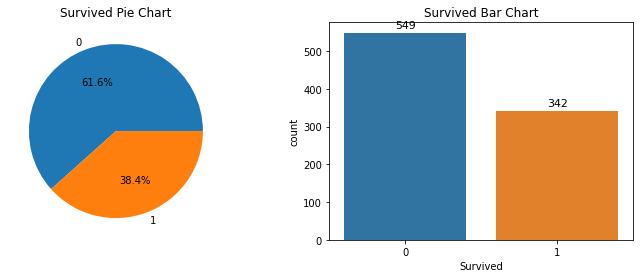

In [7]:
categorical_dist(train, 'Survived')

As inferred from the sum of survivors and non-survivors, there are 891 passengers in the training set. This represents about 40% of the total number of passengers (2224) that was aboard the Titanic. The survival rate in the training set is 38%, relatively close to the actual survival rate of 32% and hence is representative of reality.

### 2.2 Anaylzing Feature Distribution

#### 2.2.1 Categorical Feature Distribution

In [8]:
train.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


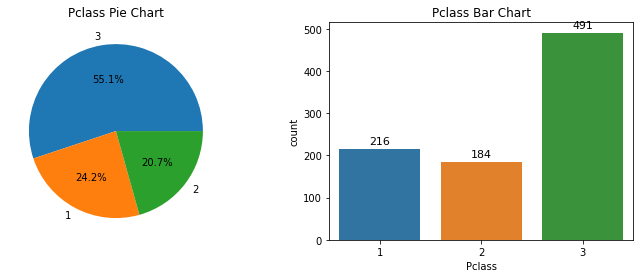

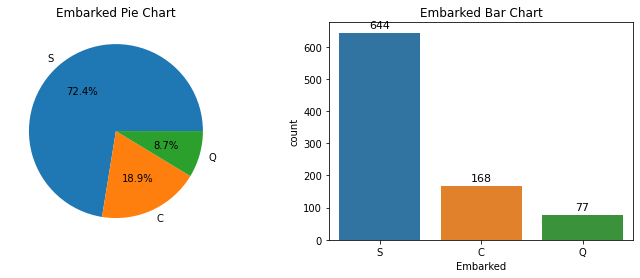

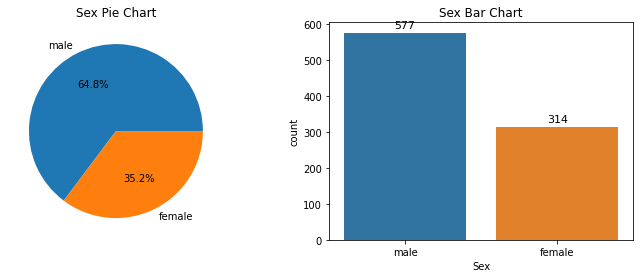

In [9]:
for i in cat_ftrs:
    categorical_dist(train, i)

- **Pclass**: More than half the passengers were in third class (55%), with the remainder being split almost equally between first and second class.
- **Embarked**: Majority of passengers (72%) embarked from port S, with very little of them from C and Q.
- **Sex**: Majority of passengers (65%) were male.

#### 2.2.2 Numerical Features Distribution

In [10]:
train[num_ftrs].describe()

,Parch,SibSp,Age,Fare
count,891.000000,891.000000,714.000000,891.000000
mean,0.381594,0.523008,29.699118,32.204208
std,0.806057,1.102743,14.526497,49.693429
min,0.000000,0.000000,0.420000,0.000000
25%,0.000000,0.000000,20.125000,7.910400
50%,0.000000,0.000000,28.000000,14.454200
75%,0.000000,1.000000,38.000000,31.000000
max,6.000000,8.000000,80.000000,512.329200


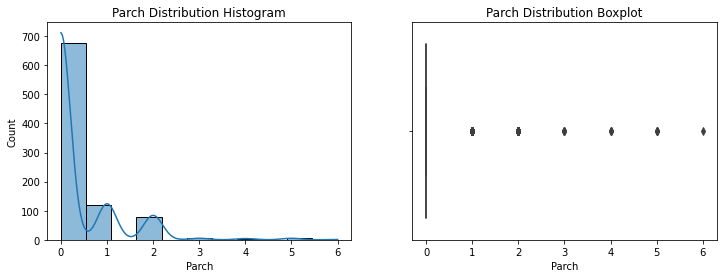

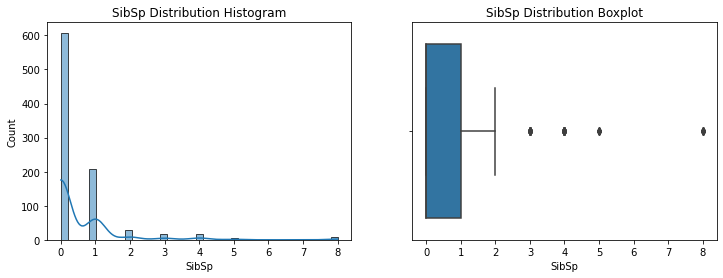

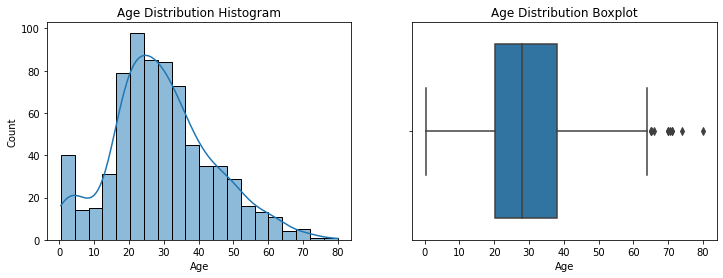

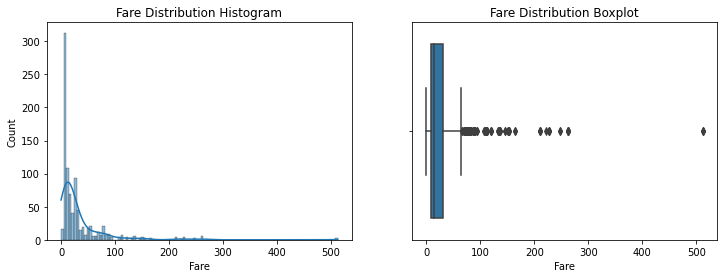

In [11]:
for i in num_ftrs:
    numerical_dist(train, i)

**Parch**: Most passengers did not have parents or children on boards.

**SibSp**: Most passengers did not come with siblings or spouses

**Age**: There is a large variation in age, ranging from 0.42 to 80 years old. 

**Fare**: Large variations in fare, whereby some passengers enter for free, and a small minority pays an upwards of 512.

Age seems to be close to a normal distribution but with a posititve skew. The other numerical features similarly follow a positive skew.

### 2.3 Analyzing Correlation to Survival
We test the features' correlation to the survival of a passenger here in order to understand the exposure each feature provides to our target.

#### 2.3.1 Pivoting  Features
We pivot Sex, Embarked, Pclass, SibSp and Parch against the target.
- Discrete, Ordinal and Nominal Features 


In [12]:
# Pivoting Sex against Survived
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [13]:
# Pivoting Embarked against Survived
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [14]:
# Pivoting Pclass against Survived
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [15]:
# Pivoting Parch agianst Survived
train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [16]:
# Pivoting SibSp against Survived
train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


Females have shown to have a higher survival rate than males, with 74% of females suriving. Passengers who embarked from Port C also have a higher survival rate of 55%, followed by port Q(38%) and lastly port S(33%). Pclass plays a role too as those from first class were also more likely to survive(62%) whereas those in third class have the lowest chance of survival(24%). 

SibSp and Parch have 0 correlation to Survived for Parch > 3 and SibSp > 4. 

**Conclusion**
- The first 3 features have shown to have some correlation with survival and will be included in our model.
- SibSp and Parch should be feature engineered to form a new feature.

#### 2.3.2 Visual Analysis

Here we analyze continuous numerical features, Age and Fare, against the target

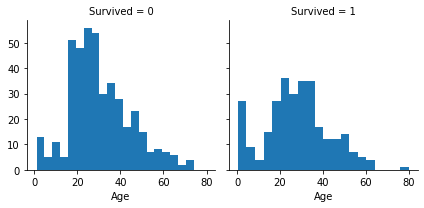

In [17]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

It is evident that children with age < 10 have a better chance of survival, while adults have a greatly reduced survival rate. Combined with the high survival rate of females, it may seem that the 'women and children' first code may have applied to the titanic incident. 

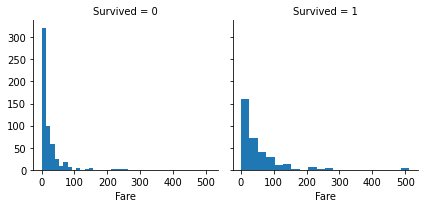

In [18]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Fare', bins=20)

We can infer that those who paid a lower fare might possibly have had lower priority to be saved. 

**Conclusion**
- Age should be included in our model 
- Test fare's correlation against Pclass.

## 2.4 Correlation between Features
Here we plot a heatmap of the correlation coefficient matrix between the features

In [19]:
# Correlation heatmap
def correlation_matrix(df, is_plot=False):
    
    # Get feature correlations and transform to dataframe
    correlated = df.corr(method='pearson')

    # Convert to abolute values
    abs_correlated = np.abs(correlated) 

    if is_plot:
        plt.figure(figsize=(10, 10))
        plt.imshow(abs_correlated, cmap='RdYlGn', interpolation='none', aspect='auto')
        plt.colorbar()
        plt.xticks(range(len(abs_correlated)), abs_correlated.columns, rotation='vertical')
        plt.yticks(range(len(abs_correlated)), abs_correlated.columns);
        plt.suptitle('Pearson Correlation Heat Map (absolute values)', fontsize=15, fontweight='bold')
        plt.show()

    return correlated, abs_correlated

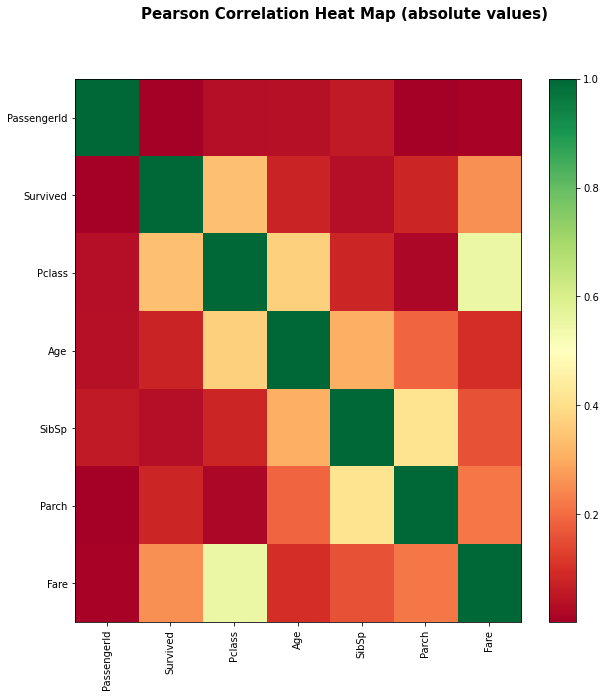

In [20]:
train_corr, train_abs_corr = correlation_matrix(train, is_plot=True)  

We can see here that Fare and Pclass have a relationship, with a Pearson Correlation coefficient of 0.5. Age and Pclass also have some correlation.

**Conclusion**
- Fare will be included in the model, but in the case of high variance may be removed or feature engineered.
- We can use Pclass as a benchmark for filling in the missing values of Fare.
- We can use Pclass as a benchmark for filling in the missing values of Age.

## 3. Data Wrangling

### 3.1 Removal
- **PassengerId** is simply just a unique identifer for the different passengers and has no relationship to survival. This is also evident from the heat map showing an extremely low correlation coefficient of PassengerId with the target.

- **Cabin** has too high a percentage of missing values in both the training and test sets and should be removed.

- **Ticket** simply serves as an identifer and has no inferrable pattern, and will hence be removed.

In [21]:
sets = [train, test]
backup = test['PassengerId'].copy()

print(f"Training set shape before: {train.shape}")
      
for df in sets:
    df.drop(['PassengerId', 'Cabin', 'Ticket'], axis=1, inplace=True)
    
print(f"After: {train.shape}")

Training set shape before: (891, 12)
After: (891, 9)


### 3.2 Feature Engineering

#### 3.2.1 Title
The names of passengers as a whole is not very useful, but we can extract titles from their names and turn them into features.

In [22]:
train['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [23]:
for df in sets:
    df['Title'] = df["Name"].str.extract('([A-Za-z]+)\.')
    df.drop("Name", axis=1, inplace=True) # Drop name column
    
train["Title"].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

As some titles mean the same thing as others, and some titles are too uncommon to really make a difference, we can clean up the current data

In [24]:
def convert_title(title):
    if title in ["Ms", "Mile", "Miss"]:
        return "Miss"
    elif title in ["Mme", "Mrs"]:
        return "Mrs"
    elif title == "Mr":
        return "Mr"
    elif title == "Master":
        return "Master"
    else:
        return "Others"

In [25]:
for df in sets:
    df["Title"] = df["Title"].map(convert_title)
    
train["Title"].value_counts()

Mr        517
Miss      183
Mrs       126
Master     40
Others     25
Name: Title, dtype: int64

#### 3.2.2 SibSp and Parch
A new feature can be created here by combining these two features to form a 'Family' feature.

In [26]:
for df in sets:
    df['Family'] = df['SibSp'] + df['Parch']
    df.drop(['SibSp', 'Parch'], axis=1, inplace=True)
    
train['Family']

0      1
1      1
2      0
3      1
4      0
      ..
886    0
887    0
888    3
889    0
890    0
Name: Family, Length: 891, dtype: int64

### 3.3 Filling of Missing Values

#### 3.3.1 Age
As Age has some correlation to Pclass as shown in the heat map above, we find the average age for each classs, and assign the passengers with missing age according to ther Pclass value.

In [27]:
train[['Pclass', 'Age']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Age
0,1,38.233441
1,2,29.877630
2,3,25.140620


In [28]:
for df in sets:
    df.loc[(df["Age"].isnull()) & (df["Pclass"]==1), 'Age'] = 38
    df.loc[(df["Age"].isnull()) & (df["Pclass"]==2), 'Age'] = 30
    df.loc[(df["Age"].isnull()) & (df["Pclass"]==3), 'Age'] = 25

#### 3.3.2 Fare

In [29]:
train[['Pclass', 'Fare']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Fare
0,1,84.154687
1,2,20.662183
2,3,13.675550


In [30]:
for df in sets:
    df.loc[(df["Fare"].isnull()) & (df["Pclass"]==1), 'Fare'] = 84
    df.loc[(df["Fare"].isnull()) & (df["Pclass"]==2), 'Fare'] = 21
    df.loc[(df["Fare"].isnull()) & (df["Pclass"]==3), 'Fare'] = 14

### 3.4 Categorical Variable Enconding and Splitting of Features and Target

For categorical variables, we need to encode them for our ML models to understand.

In [31]:
train = pd.get_dummies(train, prefix=["Sex", "Embarked", "Title"])
test = pd.get_dummies(test, prefix=["Sex", "Embarked", "Title"])

In [32]:
X_train = train.drop(["Survived"], axis=1)
y_train = train["Survived"]

In [33]:
X_test = test.copy()

## 4. Predicting and Modelling
The problem at hand is a classificiation problem to determine whether a passenger will survive based on a given set of features. As we have both features and ground truth labels to determine whether a passenger survived or not, we narrow down our possible machine learning algorithms to:

- Neural Network with Sigmoid Activation
- Logistic Regression
- Boosted Trees

Cost will be measured as the fraction of incorrect predictions. We will test all 3 algorithms and select the one with the lowest cost

### 4.1 Feature Scaling
We normalize features here for efficient training of our models

In [34]:
scaler = StandardScaler()

Xn = scaler.fit_transform(X_train)
Xn_test = scaler.fit_transform(X_test)

### 4.2 Modelling

#### 4.2.1 Neural Network with Sigmoid Activation

In [35]:
# Initiliaze model with layers
neural_model = Sequential([
            Dense(units=50, activation='relu', name='L1'),
            Dense(units=15, activation='relu', name='L2'),
            Dense(units=1, activation='sigmoid', name='L3')
          ])

neural_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

neural_model.fit(Xn, y_train, epochs=100)

Metal device set to: Apple M1 Pro
Epoch 1/100


2022-07-13 00:50:55.520106: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-13 00:50:55.520243: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-07-13 00:50:55.568182: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


12/28 [===========>..................] - ETA: 0s - loss: 0.5310

2022-07-13 00:50:55.756849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 6ms/step - loss: 0.4732
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 0.4066
Epoch 3/100
28/28 [==============================] - 0s 5ms/step - loss: 0.4012
Epoch 4/100
28/28 [==============================] - 0s 5ms/step - loss: 0.3970
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 0.3866
Epoch 6/100
28/28 [==============================] - 0s 5ms/step - loss: 0.4008
Epoch 7/100
28/28 [==============================] - 0s 5ms/step - loss: 0.3856
Epoch 8/100
28/28 [==============================] - 0s 5ms/step - loss: 0.3914
Epoch 9/100
28/28 [==============================] - 0s 5ms/step - loss: 0.3814
Epoch 10/100
28/28 [==============================] - 0s 5ms/step - loss: 0.3739
Epoch 11/100
28/28 [==============================] - 0s 5ms/step - loss: 0.3803
Epoch 12/100
28/28 [==============================] - 0s 5ms/step - loss: 0.3868
Epoch 13/100
28/28 [=============================

In [36]:
# Converting to numpy arrays for tf
y_train_np = y_train.to_numpy() 
y_train_np = y_train_np.reshape((-1, 1))

In [37]:
neural_predictions = neural_model.predict(Xn)

# Convert to Sigmoid values
neural_yhat = tf.nn.sigmoid(neural_predictions).numpy()

# Set threshold
neural_yhat = (neural_yhat >= 0.5).astype(int)

# Calculate training error
neural_error = len(neural_yhat[neural_yhat!=y_train_np]) / len(y_train_np)
print(f"The training error for Neural network is {neural_error}")

28/28 [==============================] - 0s 2ms/step
The training error for Neural network is 0.6161616161616161


2022-07-13 00:51:09.573476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


#### 4.2.2 Logistic Regression

In [38]:
logreg = LogisticRegression()
logreg.fit(Xn, y_train)
log_predictions = logreg.predict(Xn)

log_error = len(log_predictions[log_predictions!=y_train.to_numpy()]) / len(y_train)
print(f"The training error for Logistic Regression is {log_error}")

The training error for Logistic Regression is 0.16498316498316498


#### 4.2.3 Boosted Trees

In [50]:
tree = XGBClassifier()
tree.fit(Xn, y_train)
tree_pred = tree.predict(Xn)

log_error = len(tree_pred[tree_pred!=y_train.to_numpy()]) / len(y_train)
print(f"The training error for Boosted Trees is {log_error}")

The training error for Boosted Trees is 0.031425364758698095


**Conclusion for model selection**
We ultimately pick Boosted Trees as the most appropriate model due to it having the lowest training error out of the 3 models. However, further diagnosis could have been done on the Neural Network and Logistic Regression such as Bias/Variance Analysis in order to better fit the model.

## 5. Diagnosis of Model

Currently, the model has a score of 0.76555 on Kaggle, meaning that our test error is around 0.24. That is ~2.5x the training error and might hint that our model is currently overfit. There are a few methods we can consider to diagnose this problem

1. Increasing the data set
2. Decrease number of features
3. Increase regularisation

For Trees, we can consider options 1 and 2, but there is insufficient data to increase the training data set. As such, we can either increase L2 Regularisation on the model or convert continuous features into ranges based on the lowest information gain possible.

## New Submission
This submission after the retraining of Boosted Trees with the newly engineered Fare feature improved the model's score to 0.77751, and ranked 4457.

This happens despite the increase in training error of the new model.

In [60]:
final_pred = tree.predict(Xn_test)
submission = pd.DataFrame({
        "PassengerId": backup,
        "Survived": final_pred
    })

submission.to_csv('submission.csv', index=False)